# 1 План

## a) Название: Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.


## b) Описание: Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## b) Описание: Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

## c) План действий

1. Подготовить данные:
1.1. Открыть файлы и изучить их.
1.2. Провести исследовательский анализ данных.
1.3. Выполнить предобработку.
2. Постройте модель:
2.1. Обучить разные модели (условие: RANDOM_STATE = 270223) и оцените их качество (по метрике - MAE) кросс-валидацией. Выберите лучшую модель.
2.2. Проверить модель на тестовой выборке.
2.3. Сделать выводы.
3. Сделать отчет:



##  Подготовка данных (откроем файлы и изучим их):

Импортируем библиотеки:

In [1]:
pip install phik

     |████████████████████████████████| 679 kB 2.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor

Игнорируем предупреждения:

In [3]:
import warnings
warnings.filterwarnings('ignore')

Добавим структуру try... except...

In [4]:
try:
    data_arc = pd.read_csv('data_arc.csv')
    data_bulk = pd.read_csv('data_bulk.csv')
    data_bulk_time = pd.read_csv('data_bulk_time.csv')
    data_gas = pd.read_csv('data_gas.csv')
    data_temp = pd.read_csv('data_temp.csv')
    data_wire = pd.read_csv('data_wire.csv')
    data_wire_time = pd.read_csv('data_wire_time.csv')
except:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv') 
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

##  Проведем исследовательский анализ данных:

создадим функцию для просмотра данных:

In [5]:
def get_info(data):
  display(data.head(), data.tail(), data.info(), data.describe(include = 'all').T)
  print('Процент пропусков:\n', data.isna().mean().sort_values(ascending=False)*100)

создадим функцию для визуализации данных:

In [6]:
def vizualize(data, column):
  plt.figure(figsize=(10,5))
  data[column].hist(bins=100, ec='black')
  plt.title('Распределение ' + str(column), size=20)
  plt.show()
  print('')
  plt.figure(figsize=(10,5))
  sns.boxplot(data[column]);

Посмотрим на данные об электродах:

In [7]:
get_info(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
key,14876.0,NaN,NaN,NaN,1615.220422,934.571502,1.0,806.0,1617.0,2429.0,3241.0
Начало нагрева дугой,14876,14875,2019-06-10 22:02:03,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Конец нагрева дугой,14876,14876,2019-06-12 09:41:16,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Активная мощность,14876.0,NaN,NaN,NaN,0.670441,0.408159,0.030002,0.395297,0.555517,0.857034,3.731596
Реактивная мощность,14876.0,NaN,NaN,NaN,0.452592,5.878702,-715.504924,0.290991,0.415962,0.637371,2.676388


Процент пропусков:
 key                     0.0
Начало нагрева дугой    0.0
Конец нагрева дугой     0.0
Активная мощность       0.0
Реактивная мощность     0.0
dtype: float64


Посмотрим на количество значений реактивной мощности:

In [8]:
data_arc[data_arc['Реактивная мощность'] < 0]['Реактивная мощность'].value_counts()

-715.504924    1
Name: Реактивная мощность, dtype: int64

Посмотрим на распределение количчества итераций в партии:

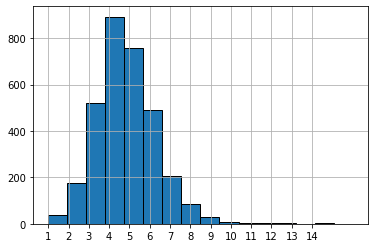

In [9]:
data_arc['key'].value_counts().hist(bins=16, ec='black')
plt.xticks(range(1,15));

Выводы:

В данных отсутствуют пропуски

Приведем дату и время к правильному формату

Реактивнная мощность имеет одно сильно отрицательное значение - удалим его

В основном партии требуется пройти от 3-х до 6-ти итераций

In [10]:
data_arc[['Начало нагрева дугой', 'Конец нагрева дугой']] = data_arc[['Начало нагрева дугой', 'Конец нагрева дугой']].astype('datetime64')

In [11]:
data_arc['Реактивная мощность'] = data_arc[data_arc['Реактивная мощность'] > 0]

Посмотрим на данные о подаче сыпучих материалов (объём):

In [12]:
get_info(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


None

,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


Процент пропусков:
 Bulk 8     99.968041
Bulk 13    99.424736
Bulk 9     99.392777
Bulk 2     99.296900
Bulk 7     99.201023
Bulk 5     97.539150
Bulk 10    94.375200
Bulk 11    94.343241
Bulk 1     91.946309
Bulk 6     81.591563
Bulk 4     67.593480
Bulk 3     58.517098
Bulk 15    28.155960
Bulk 12    21.700224
Bulk 14    10.322787
key         0.000000
dtype: float64


Выводы:

Большое количество пропусков, скорее всего материалы не добавлялись. Пропуски заменим нулями.

In [13]:
data_bulk = data_bulk.fillna(0)

Посмотрим на данные о подаче сыпучих материалов (время):

In [14]:
get_info(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 04:05:34,2019-09-01 04:05:34


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
key,3129.0,NaN,NaN,NaN,1624.383509,933.337642,1.0,816.0,1622.0,2431.0,3241.0
Bulk 1,252,252,2019-07-09 12:40:58,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 2,22,22,2019-08-08 09:34:53,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 3,1298,1298,2019-07-03 22:00:28,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 4,1014,1014,2019-08-05 22:58:07,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 5,77,77,2019-08-28 09:01:08,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 6,576,576,2019-07-26 18:26:01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 7,25,25,2019-08-08 16:25:14,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 8,1,1,2019-07-05 17:46:11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 9,19,19,2019-05-14 01:45:42,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Процент пропусков:
 Bulk 8     99.968041
Bulk 13    99.424736
Bulk 9     99.392777
Bulk 2     99.296900
Bulk 7     99.201023
Bulk 5     97.539150
Bulk 10    94.375200
Bulk 11    94.343241
Bulk 1     91.946309
Bulk 6     81.591563
Bulk 4     67.593480
Bulk 3     58.517098
Bulk 15    28.155960
Bulk 12    21.700224
Bulk 14    10.322787
key         0.000000
dtype: float64


Выводы:

Большое количество пропусков, скорее всего материалы не добавлялись. Исходя из задач проекту, вижу возможность не использовать эти данные для решения задач проекта.

Посмотрим на данные о подаче проволочных материалов (объём):

In [15]:
get_info(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


None

,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
Wire 1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
Wire 2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
Wire 3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
Wire 4,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
Wire 8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
Wire 9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


Процент пропусков:
 Wire 5    99.967543
Wire 7    99.642973
Wire 4    99.545602
Wire 8    99.383317
Wire 9    99.058747
Wire 3    97.955209
Wire 6    97.630639
Wire 2    64.978903
Wire 1     0.843882
key        0.000000
dtype: float64


Выводы:

Большое количество пропусков, скорее всего материалы не добавлялись. Пропуски заменим нулями.

In [16]:
data_wire = data_wire.fillna(0)

Посмотрим на данные о подаче проволочных материалов (время):

In [17]:
get_info(data_wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-01 04:16:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
key,3081.0,NaN,NaN,NaN,1623.426485,932.996726,1.0,823.0,1619.0,2434.0,3241.0
Wire 1,3055,3055,2019-05-30 08:35:51,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 2,1079,1079,2019-05-13 23:52:04,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 3,63,63,2019-08-21 05:05:13,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 4,14,14,2019-05-07 16:09:18,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 5,1,1,2019-08-08 16:01:07,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 6,73,73,2019-08-13 19:57:19,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 7,11,11,2019-07-23 19:16:46,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 8,19,19,2019-07-18 17:36:23,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 9,29,29,2019-06-07 14:29:39,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Процент пропусков:
 Wire 5    99.967543
Wire 7    99.642973
Wire 4    99.545602
Wire 8    99.383317
Wire 9    99.058747
Wire 3    97.955209
Wire 6    97.630639
Wire 2    64.978903
Wire 1     0.843882
key        0.000000
dtype: float64


Выводы:

Большое количество пропусков, скорее всего материалы не добавлялись. Исходя из задач проекту, вижу возможность не использовать эти данные для решения задач проекта.

Посмотрим на данные о продувке сплава газом:

In [18]:
get_info(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


None

,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


Процент пропусков:
 key      0.0
Газ 1    0.0
dtype: float64


Посмотрим на распределение:

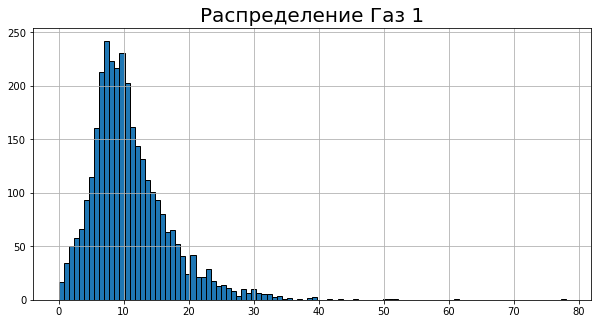

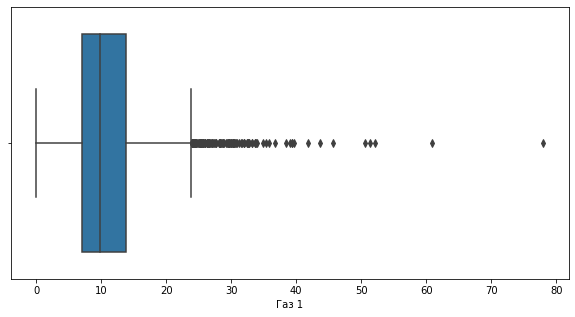

In [19]:
vizualize(data_gas, 'Газ 1')

Посмотрим на пределы нормальных значений

In [20]:
q25 = np.array(data_gas['Газ 1'].quantile(0.25))
q75 = np.array(data_gas['Газ 1'].quantile(0.75))
print('25% - ',q25, '75% - ', q75)
print('Верхний порог', q75+3*(q75-q25))
print('Кол-во партий с аномально большим объёмом', data_gas[data_gas['Газ 1'] > q75+3*(q75-q25)]['key'].count())

25% -  7.04308867105 75% -  13.7699154369
Верхний порог 33.95039573445
Кол-во партий с аномально большим объёмом 18


Выводы:

Можно выделить маленькие значения близкие к нулю и некотрые выбросы в большую сторону.

Нормальные значения расположены в диапазоне 7,04 - 13,77.

Верхний порог 33,95,  таких значений всего 18, поэтому трогать их  не будем.

Посмотрим на результаты измерения температуры:

In [21]:
get_info(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


,key,Время замера,Температура
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
key,15907.0,NaN,NaN,NaN,1607.88087,942.212073,1.0,790.0,1618.0,2427.0,3241.0
Время замера,15907,15907,2019-06-25 18:16:36,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Температура,13006.0,NaN,NaN,NaN,1591.84092,21.375851,1191.0,1581.0,1591.0,1601.0,1705.0


Процент пропусков:
 Температура     18.237254
key              0.000000
Время замера     0.000000
dtype: float64


Посмотрим на распределение:

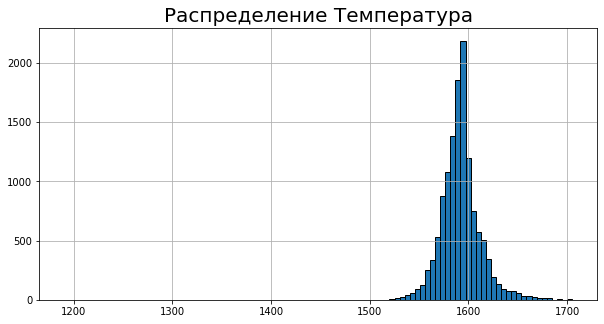

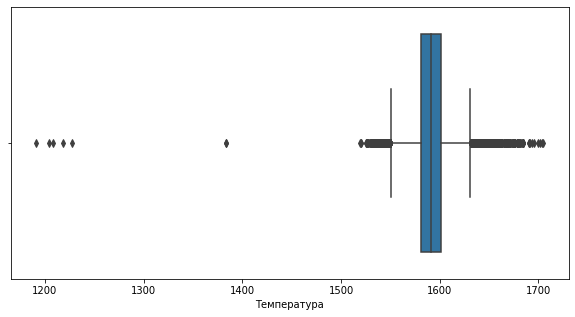

In [22]:
vizualize(data_temp, 'Температура')

Выводы:

Наличие пропусков в значениях температуры 18,24% от всех данных, удалим их. Есть выбросы в минимальную сторону, удалим их. 

Приведем дату и время к правильному формату

In [23]:
data_temp['Время замера'] = data_temp['Время замера'].astype('datetime64')

In [24]:
data_temp = data_temp.dropna()

In [25]:
data_temp = data_temp.query('Температура > 1400')

По условию задачи целевым признаком является последняя измеренная температура, преобразуем данные:

In [26]:
data_measurement_temp = data_temp.groupby('key', as_index=False).agg(Температура_начальная = ( 'Температура','first'), Температура_конечная = ( 'Температура','last'))

Найдем значение разности температур:

In [27]:
data_measurement_temp['Разность_температур'] = data_measurement_temp['Температура_конечная'] - data_measurement_temp['Температура_начальная']

Удалим строки, где равность температур равна нулю:

In [28]:
data_measurement_temp = data_measurement_temp.drop(np.where(data_measurement_temp['Разность_температур'] == 0)[0])

Удалим стлбец разности температур:

In [29]:
data_measurement_temp = data_measurement_temp.drop(['Разность_температур'], axis = 1)

In [30]:
data_measurement_temp

,key,Температура_начальная,Температура_конечная
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2472,2495,1570.0,1591.0
2473,2496,1554.0,1591.0
2474,2497,1571.0,1589.0
2475,2498,1591.0,1594.0


Так же найдем значения полной мощности, энергии и времени нагрева и количество нагревов

In [31]:
data_arc['Полная мощность'] = (data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)**0.5

In [32]:
data_arc['Время нагрева'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.total_seconds()

In [33]:
data_arc['Количество нагревов'] = data_arc.groupby('key')['Время нагрева'].agg(['count'])

In [34]:
data_arc['Энергия'] = data_arc['Полная мощность'] * data_arc['Время нагрева']

Объединим данные по значению key просуммировав значения:

In [35]:
data_arc = data_arc.groupby('key').agg({'Начало нагрева дугой': 'min',
                                        'Конец нагрева дугой': 'max',
                                        'Активная мощность': 'sum',
                                        'Реактивная мощность': 'sum',
                                        'Полная мощность': 'sum',
                                        'Время нагрева': 'sum',
                                        'Количество нагревов': 'sum',
                                        'Энергия': 'sum'
                                        })

In [36]:
data_arc

,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева,Количество нагревов,Энергия
key,,,,,,,,
1,2019-05-03 11:02:14,2019-05-03 11:28:37,4.878147,5.0,7.082055,1098.0,18.0,1.657781e+03
2,2019-05-03 11:34:14,2019-05-03 11:53:18,3.052598,8.0,8.654596,811.0,16.0,1.800106e+03
3,2019-05-03 12:06:54,2019-05-03 12:32:19,2.525882,15.0,15.277222,655.0,26.0,2.026060e+03
4,2019-05-03 12:39:37,2019-05-03 12:57:50,3.209250,16.0,16.358048,741.0,19.0,3.045681e+03
5,2019-05-03 13:11:13,2019-05-03 13:33:55,3.347173,20.0,20.378751,869.0,19.0,4.477767e+03
...,...,...,...,...,...,...,...,...
3237,2019-08-31 22:41:18,2019-08-31 23:03:48,3.932467,16185.0,16185.000528,909.0,0.0,2.942433e+06
3238,2019-08-31 23:26:18,2019-08-31 23:41:28,2.106529,9714.0,9714.000261,546.0,0.0,1.767948e+06
3239,2019-09-01 01:26:53,2019-09-01 02:15:43,4.666754,25912.0,25912.000504,1216.0,0.0,3.938624e+06


Посмотрим на распределение продолжительности нагрева.

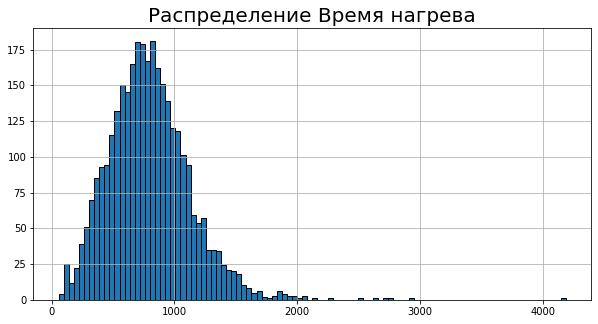

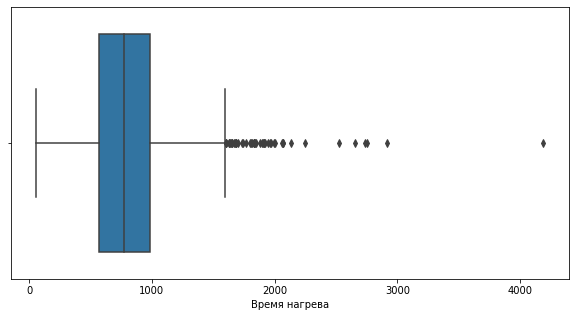

In [37]:
vizualize(data_arc, 'Время нагрева')

Выводы

Видны выбросы в большую сторону, но пока их трогать не будем

Вывод:
по некоторым партиям полностью отсутствует информация о добавленных материалах
во всех рассмотренных данных имеется некоторое количество выбросов
избавились от аномального выброса по реактивной мощности
выявлено сильную линейную зависимость между временем нагрева, активной и реактивной мощностью
не выявлено каких-то изменений по признакам со временем
измеренная температура больше всего линейно зависит от параметров: 'Энергия', 'Реактивная мощность', 'Полная мощность'

Объединим таблицы:

In [38]:
data_full = (data_measurement_temp.merge(data_arc, on='key', how='inner').
             merge(data_bulk, on='key', how='inner').
             merge(data_wire, on='key', how='inner').
             merge(data_gas, on='key', how='inner'))

In [39]:
data_full

,key,Температура_начальная,Температура_конечная,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева,Количество нагревов,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
0,1,1571.0,1613.0,2019-05-03 11:02:14,2019-05-03 11:28:37,4.878147,5.0,7.082055,1098.0,18.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,1581.0,1602.0,2019-05-03 11:34:14,2019-05-03 11:53:18,3.052598,8.0,8.654596,811.0,16.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,1596.0,1599.0,2019-05-03 12:06:54,2019-05-03 12:32:19,2.525882,15.0,15.277222,655.0,26.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,1601.0,1625.0,2019-05-03 12:39:37,2019-05-03 12:57:50,3.209250,16.0,16.358048,741.0,19.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,1576.0,1602.0,2019-05-03 13:11:13,2019-05-03 13:33:55,3.347173,20.0,20.378751,869.0,19.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2287,2495,1570.0,1591.0,2019-08-06 00:31:05,2019-08-06 00:51:13,3.210690,9980.0,9980.000558,723.0,0.0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735
2288,2496,1554.0,1591.0,2019-08-06 01:00:06,2019-08-06 01:23:32,4.203064,14976.0,14976.000663,940.0,0.0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616
2289,2497,1571.0,1589.0,2019-08-06 01:38:01,2019-08-06 01:50:45,2.212379,7491.0,7491.000334,569.0,0.0,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271699
2290,2498,1591.0,1594.0,2019-08-06 01:57:46,2019-08-06 02:20:24,3.408725,12490.0,12490.000574,750.0,0.0,...,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.953657


In [40]:
#data_measurement_temp

## Анализ данных

Посмотрим на корреляцию признаков:

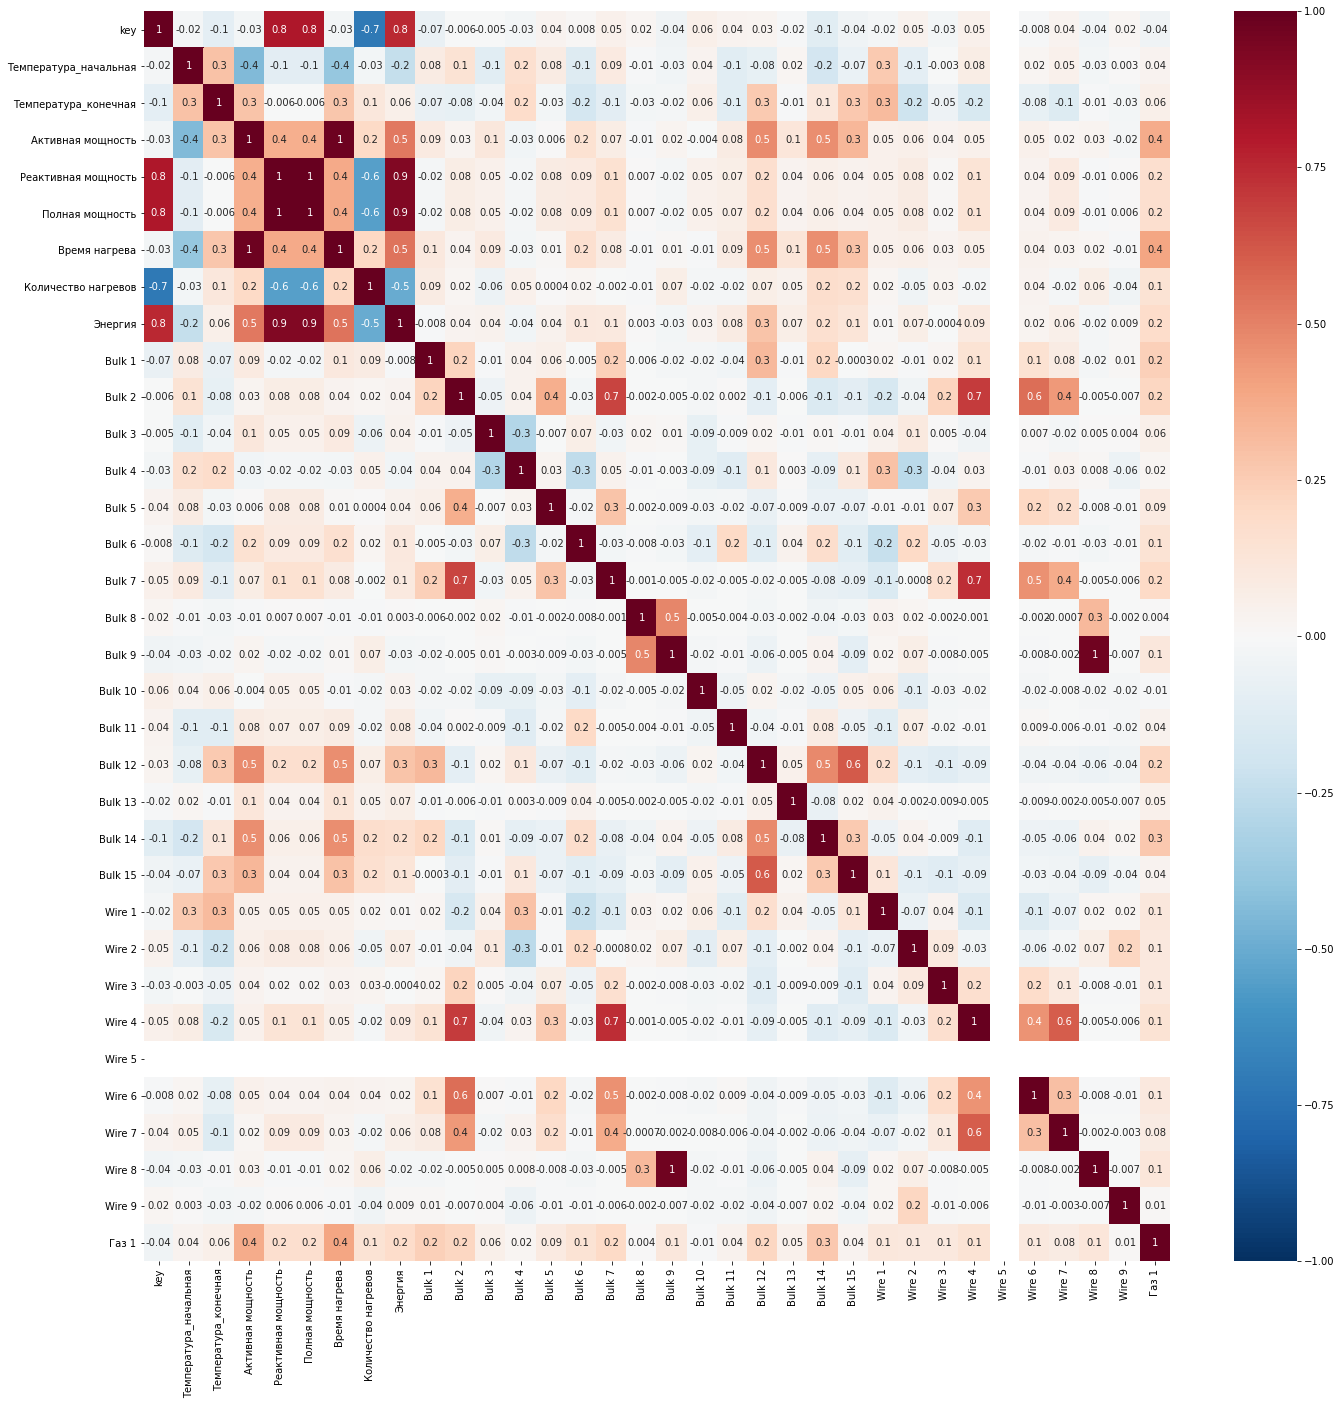

In [41]:
plt.figure(figsize=(23, 23))
sns.heatmap(data_full.corr(),
            annot=True,
            cmap='RdBu_r',
            fmt='.1g',
            vmin=-1,
            vmax=1)
plt.show()  

Здесь мы видим что признаки энергии и мощностей сильно коррелируют относительно друг друга. Посмотрим поближе.

Посмотрим на на данные, где корреляция больше 0,9

In [42]:
def corr_more_09(data):
  data = data.corr()
  data = data[((data != 1) & (data > 0.9))]

  for column in data.columns:
    if data[column].notna().sum() == 0:
      data = data.drop(column, axis=1)

  for idx in data.index:
    if data.loc[idx,:].notna().sum() == 0:
      data = data.drop(idx)

  return data

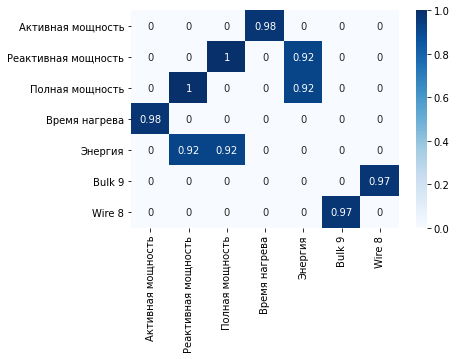

In [43]:
data_new = corr_more_09(data_full).fillna(0)
sns.heatmap(data_new, annot=True, cmap='Blues');

Посмотрим на корреляцию признаков к целевому признаку:

%%time

phik_matrix = data_full.phik_matrix();
plt.figure(figsize=(2,10))
sns.heatmap(phik_matrix['Температура'].sort_values(ascending=False).to_frame(), annot=True, cmap='Blues');

Удалим признаки, не влияющие на температуру и коррелирующие между собой "Bulk 9", избавимся от признаков мощности, так как они уже учтены в энергии. Так же удалим столбцы, содержащие дату и время. Оставим признаки, которые больше всего оказывают влияние на измененную температуру. Удалим следующие столбцы: 'Активная мощность', 'Реактивная мощность', 'Полная мощность', 'key', 'Время замера', 'Начало нагрева дугой', 'Конец нагрева дугой'. Так же удалим key, так как это не признак.

In [44]:
data_full = data_full.drop(['Активная мощность', 'Реактивная мощность', 'Полная мощность', "Bulk 9",'Начало нагрева дугой', 'Конец нагрева дугой','key'], axis=1)

In [45]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2292 entries, 0 to 2291
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Температура_начальная  2292 non-null   float64
 1   Температура_конечная   2292 non-null   float64
 2   Время нагрева          2292 non-null   float64
 3   Количество нагревов    2292 non-null   float64
 4   Энергия                2292 non-null   float64
 5   Bulk 1                 2292 non-null   float64
 6   Bulk 2                 2292 non-null   float64
 7   Bulk 3                 2292 non-null   float64
 8   Bulk 4                 2292 non-null   float64
 9   Bulk 5                 2292 non-null   float64
 10  Bulk 6                 2292 non-null   float64
 11  Bulk 7                 2292 non-null   float64
 12  Bulk 8                 2292 non-null   float64
 13  Bulk 10                2292 non-null   float64
 14  Bulk 11                2292 non-null   float64
 15  Bulk

Вывод:
по некоторым партиям полностью отсутствует информация о добавленных материалах
во всех рассмотренных данных имеется некоторое количество выбросов
избавились от аномального выброса по реактивной мощности
выявлено сильную линейную зависимость между временем нагрева, активной и реактивной мощностью
не выявлено каких-то изменений по признакам со временем
измеренная температура больше всего линейно зависит от параметров: 'Энергия', 'Реактивная мощность', 'Полная мощность'

Подготовим признаки и разделим выборку для обучения модели:

In [46]:
feat = data_full.drop('Температура_конечная', axis=1)
target = data_full['Температура_конечная']

feat_train, feat_test, target_train, target_test = \
    train_test_split(feat, target, test_size=0.25, random_state=12345)

Оценим размеры выборок:

In [47]:
print(feat_train.shape)
print(target_train.shape)
print(feat_test.shape)
print(target_test.shape)

(1719, 28)
(1719,)
(573, 28)
(573,)


# 2 Модель: Код

Масштабируем данные:

Некоторые модели чувствительны с значениям, поэтому необходимо произвести масштабирование. Используем StandardScaler, так как у нас нет большого количества сильных выбросов, да и требования к масштабированию не определены.

In [48]:
scaler = StandardScaler()
feat_train_ss = scaler.fit_transform(feat_train)
feat_test_ss = scaler.transform(feat_test)

Обучим модель RandomForestRegressor:

In [49]:
%%time

rfr = RandomForestRegressor(random_state = 270223)

model_rfr = GridSearchCV(rfr, {'max_depth': [3, 5, 8, 10, 12],'min_samples_leaf': [2, 3, 4, 5, 6, 10, 13],'n_estimators': [3, 1, 4, 6, 8, 10, 12, 15]}, cv = 5, scoring='neg_mean_absolute_error')
model_rfr.fit(feat_train, target_train)
print(model_rfr.best_params_)
print("MAE_RandomForestRegressor:", (model_rfr.best_score_*(-1)))

{'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 15}
MAE_RandomForestRegressor: 6.390691594196674
CPU times: user 56.8 s, sys: 168 ms, total: 57 s
Wall time: 57.3 s


Обучим модель LinearRegression:

In [51]:
%%time

lr = LinearRegression()

model_lr = GridSearchCV(lr, {'n_jobs':[8, 10],}, cv = 5, scoring = 'neg_mean_absolute_error')
model_lr.fit(feat_train_ss, target_train)
print(model_lr.best_params_)
print("MAE_LinearRegression:", (model_lr.best_score_*(-1)))

{'n_jobs': 8}
MAE_LinearRegression: 6.440129198546875
CPU times: user 445 ms, sys: 1.91 s, total: 2.35 s
Wall time: 2.57 s


Обучим модель LGBMRegressor:

In [52]:
%%time

lgbm = LGBMRegressor(random_state = 270223)

model_lgbm = GridSearchCV(lgbm, {'num_leaves':[5, 7], 'learning_rate':[0.1, 0.3]}, verbose = 2, cv = 2, scoring='neg_mean_absolute_error')
model_lgbm.fit(feat_train, target_train)
print(model_lgbm.best_params_)
print("MAE_LGBMRegressor:", (model_lgbm.best_score_*(-1)))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END ....................learning_rate=0.1, num_leaves=5; total time=  58.8s
[CV] END ....................learning_rate=0.1, num_leaves=5; total time= 1.1min
[CV] END ....................learning_rate=0.1, num_leaves=7; total time= 1.4min
[CV] END ....................learning_rate=0.1, num_leaves=7; total time= 1.4min
[CV] END ....................learning_rate=0.3, num_leaves=5; total time=  57.8s
[CV] END ....................learning_rate=0.3, num_leaves=5; total time=  57.8s
[CV] END ....................learning_rate=0.3, num_leaves=7; total time= 1.4min
[CV] END ....................learning_rate=0.3, num_leaves=7; total time= 1.4min
{'learning_rate': 0.1, 'num_leaves': 5}
MAE_LGBMRegressor: 6.443121563777176
CPU times: user 10min 25s, sys: 5.65 s, total: 10min 31s
Wall time: 10min 35s


Обучим модель CatBoostRegressor:

In [53]:
%%time

cb = CatBoostRegressor(random_state = 270223)

model_cb = GridSearchCV(cb, {'depth':[5, 10], 'learning_rate':[0.1, 0.3]}, verbose = 2, cv = 2, scoring='neg_mean_absolute_error')
model_cb.fit(feat_train, target_train)
print(model_cb.best_params_)
print("MAE_CatBoostRegressor:", (model_cb.best_score_*(-1)))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
0:	learn: 10.9312227	total: 48.3ms	remaining: 48.3s
1:	learn: 10.7050323	total: 50.2ms	remaining: 25s
2:	learn: 10.4939322	total: 51.8ms	remaining: 17.2s
3:	learn: 10.2888299	total: 53.5ms	remaining: 13.3s
4:	learn: 10.1203138	total: 55.1ms	remaining: 11s
5:	learn: 9.9758267	total: 56.7ms	remaining: 9.39s
6:	learn: 9.8269052	total: 58.2ms	remaining: 8.25s
7:	learn: 9.7165687	total: 59.6ms	remaining: 7.39s
8:	learn: 9.5813075	total: 61.1ms	remaining: 6.73s
9:	learn: 9.4347212	total: 62.7ms	remaining: 6.21s
10:	learn: 9.3254561	total: 64.4ms	remaining: 5.79s
11:	learn: 9.2240634	total: 66ms	remaining: 5.43s
12:	learn: 9.1520177	total: 67.5ms	remaining: 5.13s
13:	learn: 9.0598576	total: 68.9ms	remaining: 4.85s
14:	learn: 8.9588985	total: 71ms	remaining: 4.67s
15:	learn: 8.9026081	total: 73.2ms	remaining: 4.5s
16:	learn: 8.8323716	total: 75.3ms	remaining: 4.35s
17:	learn: 8.7425377	total: 77.6ms	remaining: 4.23s
18:	learn: 8.687784

Лучшие результаты средней абсолютной ошибки (МАЕ) кросс-валидации получила модель MAE_RandomForestRegressor: 6.39

Посмотрим на важность признаков:

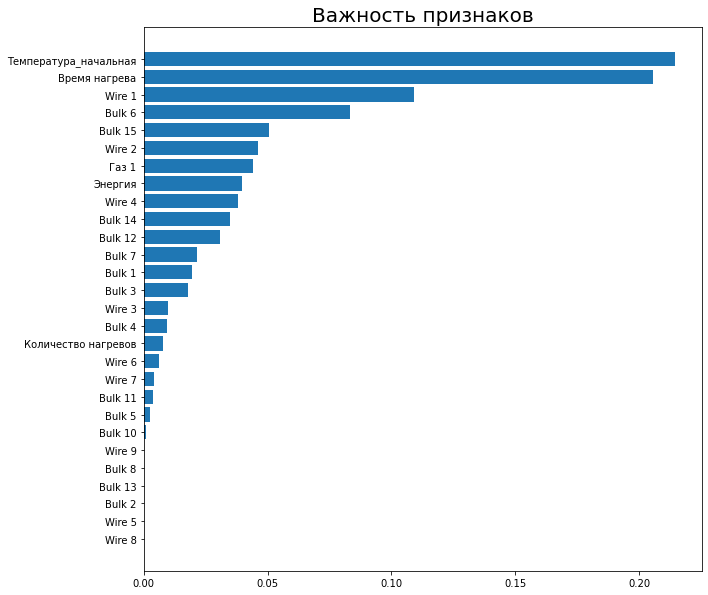

In [54]:
feature_importance = model_rfr.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feat.columns)[sorted_idx])
plt.title('Важность признаков', size=20);

In [55]:
feature_importance_data = pd.DataFrame(model_rfr.best_estimator_.feature_importances_, index = feat.columns)
feature_importance_data.sort_values(0)

,0
Wire 8,0.000000
Wire 5,0.000000
Bulk 2,0.000000
Bulk 13,0.000000
Bulk 8,0.000000
Wire 9,0.000090
Bulk 10,0.001100
Bulk 5,0.002490
Bulk 11,0.003747
Wire 7,0.004039


На первом месте начальная температура и время нагрева. 
Основными факторами, требующих дополнительного нагрева, а следовательно и энергии являются:
Проволочный материал №1  и сыпучий материал №6 и №15(возможно элемент является тугоплавким и для его расплавления требуется больше нагрева энергии)
Так же объём потребляемого газа (вероятнее всего чем больше подаётся газа, тем больше требуется нагревать сплав)

Проверка модели на тестовой выборке:

In [50]:
predicted = model_rfr.best_estimator_.predict(feat_test)
test_mae = mean_absolute_error(target_test, predicted)
print(test_mae)

6.203732954065336


Модель можно считать успешной

Проведём сравнение с констатной моделью (DummyRegressor).

In [51]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(feat_train, target_train)
dummy_predicted = dummy_regr.predict(feat_test)
dummy_test_mae = mean_absolute_error(target_test, dummy_predicted)
print(dummy_test_mae)

8.117619826454554


# 3 Отчет

Перед нами стояла задача построить модель, которая предскажет последнюю измеренную температуру стали. 
В будующем такая модель должна помочь оптимизировать затраты на потребления электроэнергии на этапе обработки стали.

1.1. Мы изучили данные, провели исследовательский анализ и выполонили предобработку:

В данных реактивной мощности отсутствовали пропуски, имелось одно аномальное отрицательное значение, мы его удалили
В основном в партии требовалось от 3 до 6 итераций.

В данных о подаче сыпучих материалов (объём) было большое количество пропусков, которое связано с тем, что материалы не добалвялись, пропуски заменили нулевыми значениями

В данных о подаче сыпучих материалов (время), так же было большое количество пропусков, исходдя из задач проекта мы не использовали эти данные и удалили их

В данных о подаче проволочных материалов (объём) было большое количество пропусков, которое связано с тем, что материалы не добалвялись, пропуски заменили нулевыми значениями

В данных о подаче проволочных материалов (время), так же было большое количество пропусков, исходдя из задач проекта мы не использовали эти данные и удалили их

В данных о  продувке сплава газом можно выделить маленькие значения близкие к нулю и некотрые выбросы в большую сторону.
Нормальные значения расположены в диапазоне 7,04 - 13,77.
Верхний порог 33,95, таких значений всего 18, поэтому мы их оставили.

В данных измерения температуры бли пропуски в значениях температуры 18,24% от всех данных, удалили их. Та же были выбросы в минимальную сторону, удалили их.

1.2. По условию задачи целевым признаком является последняя измеренная температура, мы добавили дополнительные признаки начальной о конечной температуры, а где их значения совпадали, мы их удалили.
Добавили дополнительные признаки полной мощности, энергии, времени и количества нагревов.
Посмотрели на корреляцию признаков и определили, что признаки энергии и мощностей сильно коррелируют относительно друг друга, так же "Bulk 9" и "Wire 8"
Мы удалили значения признаков мощности, так как они уже учтены в энергии, значение "Bulk 9" и столбцы, содержащие дату и время. Так же удалим key, так как это не признак.

2.1. Все данные были объеденены в одну таблицу по ключу key (значения просуммированы) и переданы следующим моделям для обучения:
RandomForestRegressor(с результатом МАЕ = "6,390" и со следующими гиперпарамметрами: random_state = 270223, {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 15}), 

LinearRegression(с результатом МАЕ = "6.440" и со следующими гиперпарамметрами: random_state = 270223, {'learning_rate': 0.1, 'num_leaves': 5}), 

LGBMRegressor(с результатом МАЕ = "6.443" и со следующими гиперпарамметрами: random_state = 270223, {'n_jobs': 8}), 

CatBoostRegressor(с результатом МАЕ = "6.624" и со следующими гиперпарамметрами: random_state = 270223, {'depth': 5, 'learning_rate': 0.1})

Лучшие результаты средней абсолютной ошибки (МАЕ) кросс-валидации получила модель "RandomForestRegressor"(6,39). 

2.2. На тесте эта модель "RandomForestRegressor" получила значение МАЕ = "6,20", со следующими гиперпарамметрами: random_state = 270223, {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 15}
Модель можно считать успешной. Задачу выполненной.

3.1. Следует отметить значимость признаков: на первом месте начальная температура (0.214) и время нагрева(0.205). 
Основными факторами, требующих дополнительного нагрева, а следовательно и энергии являются: 
Проволочный материал №1(0.109), №2(0.045) и сыпучий материал №6(0.083), №15(0.050) (возможно элементы являются тугоплавкими и для их расплавления требуется больше нагрева энергии). 
Так же объём потребляемого газа(0.044) (вероятнее всего чем больше подаётся газа, тем больше требуется нагревать сплав)

Основными трудностями для меня были, подбор признаков, для получения качества модели достаточного для выполнения задачи, с которыми, я считаю, мне совместно с командой удалось справиться, спасибо большое команде за работу!!!